In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from enum import Enum
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [68]:
xe136cross=pd.read_csv('../crosssections/Xe136_N_XSec.csv',engine='python',header=None,delim_whitespace=True)
xe131cross=pd.read_csv('../crosssections/Xe131_N_XSec.csv',engine='python',header=None,delim_whitespace=True)
xe126cross=pd.read_csv('../crosssections/Xe126_N_XSec.csv',engine='python',header=None,delim_whitespace=True)
He3cross=pd.read_csv('../crosssections/He3_N_XSec.csv',engine='python',header=None,delim_whitespace=True)

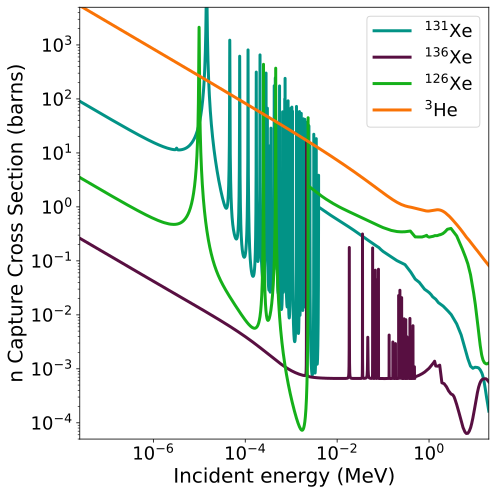

In [69]:
plt.figure(figsize=(7,7))

plt.plot(xe131cross[0]*1e-6,xe131cross[1],label="$^{131}$Xe",color='xkcd:teal',lw=3)
plt.plot(xe136cross[0]*1e-6,xe136cross[1],label="$^{136}$Xe",color='xkcd:plum',lw=3)
plt.plot(xe126cross[0]*1e-6,xe126cross[1],label="$^{126}$Xe",color='xkcd:green',lw=3)
plt.plot(He3cross[0]*1e-6,He3cross[1],label="$^{3}$He",color='xkcd:orange',lw=3)

plt.semilogx()
plt.semilogy()
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylim(5e-5,5000)  
plt.xlim(25e-9,20)
plt.ylabel("n Capture Cross Section (barns)",fontsize=20)
plt.xlabel('Incident energy (MeV)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc='upper right')
plt.show()

Thermal and Fast Neutrons

In [70]:
# Enums for plotting
class Xe(Enum):
    k_Xe131_Th = 0
    k_Xe126_Th = 1
    k_Xe131_F  = 2
    k_Xe126_F  = 3

# Names of elements and type to plot
names = ["Xe131_Thermal", "Xe126_Thermal", "Xe131Fast", "Xe126Fast"]

# The corresponding paths to the names above
files = ["../outputs/Xe131Thermal/*", "../outputs/Xe126Thermal/*", "../outputs/Xe131Fast/*", "../outputs/Xe126Fast/*"]

neutrons = []
# Load in the files
for f in files:
    neutrons.append(sorted(glob.glob(f), reverse=True))

In [71]:
# Get the main information from the file for this study
neutrons_E     = [] # Array of array of dataframe containing energies of thermal neutrons
neutrons_Xe137 = [] # Array of array of Total Xe137 produced
Metadata       = [] # Array of array of metadata
neutrons_tot   = [] # Array of array of Total simulated neutrons
pct            = [] # Array of array containing percentages run

# Loop over the files
for n in neutrons:

    temp_neutrons_E     = []
    temp_neutrons_Xe137 = []
    temp_Metadata       = []
    temp_neutrons_tot   = []
    temp_pct            = []
    
    # Load in the dataframes
    for idx, f in enumerate(n):
        temp_neutrons_E    .append(pd.read_hdf(f,'Energy'))
        temp_neutrons_Xe137.append(len(temp_neutrons_E[idx]))
        temp_Metadata      = pd.read_hdf(f,'Metadata')
        temp_neutrons_tot  .append(temp_Metadata['Num_Events'].sum())
        temp_pct           .append(float(temp_Metadata['Percentage'].iloc[0]))

        # print(temp_neutrons_tot[idx], temp_neutrons_Xe137[idx], temp_pct[idx])

    neutrons_E.append(temp_neutrons_E)
    neutrons_Xe137.append(temp_neutrons_Xe137)
    Metadata.append(temp_Metadata)
    neutrons_tot.append(temp_neutrons_tot)
    pct.append(temp_pct)


In [72]:
# Standard Parameters
Active_Mass  = 1109     # Total mass in the active volume of the detector


neutrons_tot_norm = []
# Loop over the types
for idx, n in enumerate(neutrons):
    
    # Normalised events = (N137 / Enrich * Pct * M ) / total
    neutrons_Xe137[idx] = np.asarray(neutrons_Xe137[idx])
    neutrons_tot[idx]   = np.asarray(neutrons_tot[idx])
    pct[idx]            = np.asarray(pct[idx])

    Enrich_Xe136 = (0.902616 + 0.00234361) - 0.01*pct[idx] # Enrichment of Xenon 136
    # print(Enrich_Xe136)

    neutrons_tot_norm.append(neutrons_Xe137[idx] / ( neutrons_tot[idx] * Enrich_Xe136 * Active_Mass))


In [73]:
# Calculate the Statistical Uncertainties
neutrons_Err      = [] # Statistical Uncertainty

for idx in range(0 , len(neutrons)):

    temp_neutrons_Err = []

    for p in range(0 , len(neutrons_Xe137[idx])):

        if neutrons_Xe137[idx][p] == 0:
            temp_neutrons_Err.append(0.0)
        else: 
            temp_neutrons_Err.append(neutrons_tot_norm[idx][p] * np.sqrt(1 / neutrons_Xe137[idx][p]))

    neutrons_Err.append(temp_neutrons_Err)


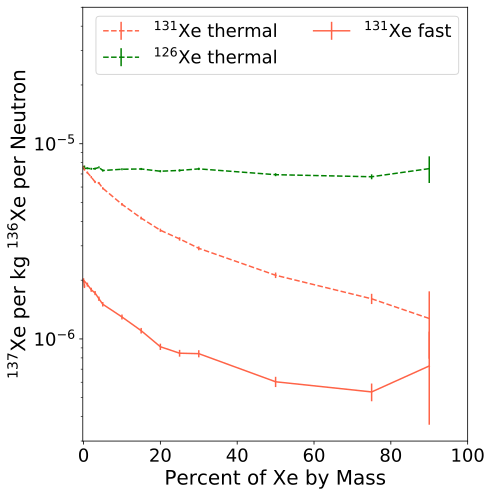

In [74]:
# Make the Plot
plt.figure(figsize=(7,7))
# plt.errorbar(100 - pct, Fneutrons_tot_norm, color="k", yerr=Fneutrons_Err,fmt='s',label="$^{3}$He fast",ms=7, ls='--')
plt.errorbar(pct[Xe.k_Xe131_Th.value], neutrons_tot_norm[Xe.k_Xe131_Th.value], color="tomato", yerr=neutrons_Err[Xe.k_Xe131_Th.value],fmt='-',label="$^{131}$Xe thermal",ms=9, ls='--')
plt.errorbar(pct[Xe.k_Xe126_Th.value], neutrons_tot_norm[Xe.k_Xe126_Th.value], color="green", yerr=neutrons_Err[Xe.k_Xe126_Th.value],fmt='-',label="$^{126}$Xe thermal",ms=9, ls='--')

plt.errorbar(pct[Xe.k_Xe131_F.value], neutrons_tot_norm[Xe.k_Xe131_F.value], color="tomato", yerr=neutrons_Err[Xe.k_Xe131_F.value],fmt='-',label="$^{131}$Xe fast",ms=9, ls='-')
plt.errorbar(pct[Xe.k_Xe126_F.value], neutrons_tot_norm[Xe.k_Xe126_F.value], color="green", yerr=neutrons_Err[Xe.k_Xe126_F.value],fmt='-',label="$^{126}$Xe fast",ms=9, ls='-')

plt.semilogy()
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.xlim(-.2,100) 

plt.ylim(3e-7,5e-5)  
plt.ylabel("$^{137}$Xe per kg $^{136}$Xe per Neutron",fontsize=20)
plt.yticks(fontsize=18) 
plt.xlabel('Percent of Xe by Mass',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc=1,ncol=2)
plt.show()